Shape X_seq: (17282, 10, 3)
Shape y_seq: (17282, 3)
Epoch 1/500


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


217/217 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.6249 - val_loss: 0.4153 - learning_rate: 0.0010
Epoch 2/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4115 - val_loss: 0.2934 - learning_rate: 0.0010
Epoch 3/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3356 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 4/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3082 - val_loss: 0.2211 - learning_rate: 0.0010
Epoch 5/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2502 - val_loss: 0.1945 - learning_rate: 0.0010
Epoch 6/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2224 - val_loss: 0.1880 - learning_rate: 0.0010
Epoch 7/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.2289 - val_loss: 0.1653 - learning_rate: 0.0010
Epoch 8/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1926 - val_loss: 0.1594 - learning_rate: 0.0010
Epoch 9/500
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2063 - val_loss: 0.1570 - learning_rate: 0.0010
Epoch 10/500


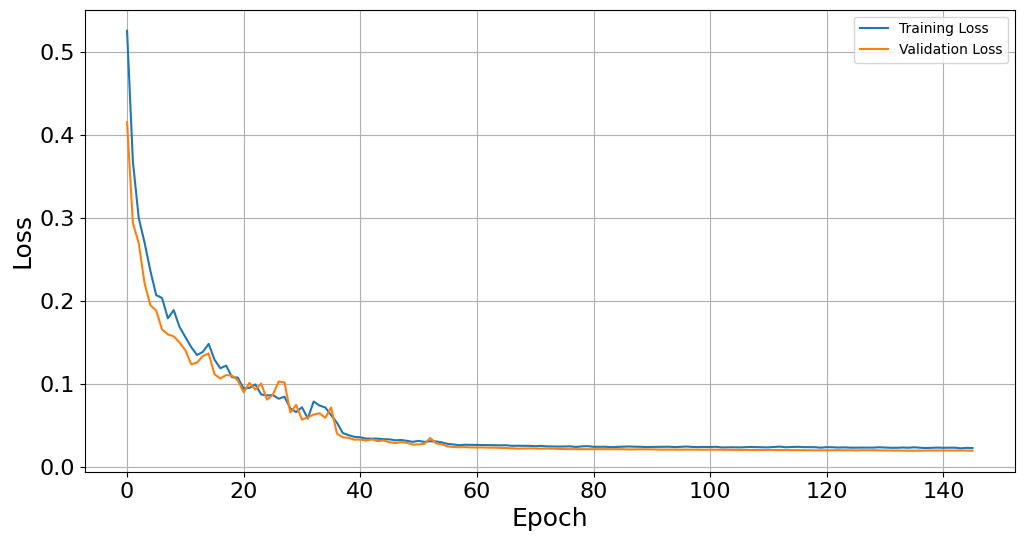

109/109 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MSE Fx: 0.15986516990164837, R² Fx: 0.9839249775802997
MSE Fy: 0.3645889626246089, R² Fy: 0.9841399987467252
MSE Fz: 2.7200844772166723, R² Fz: 0.9755422195810928


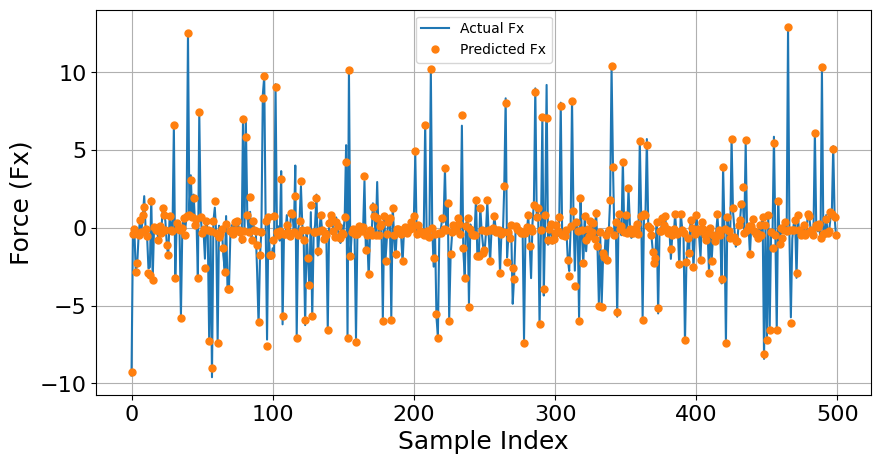

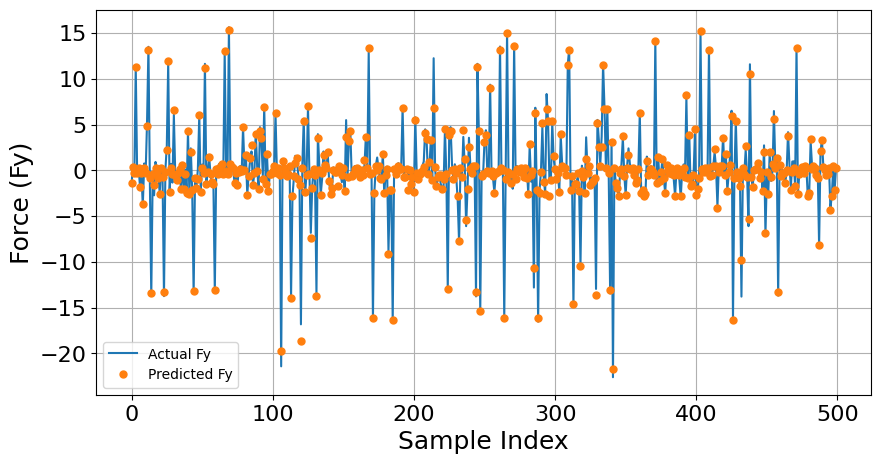

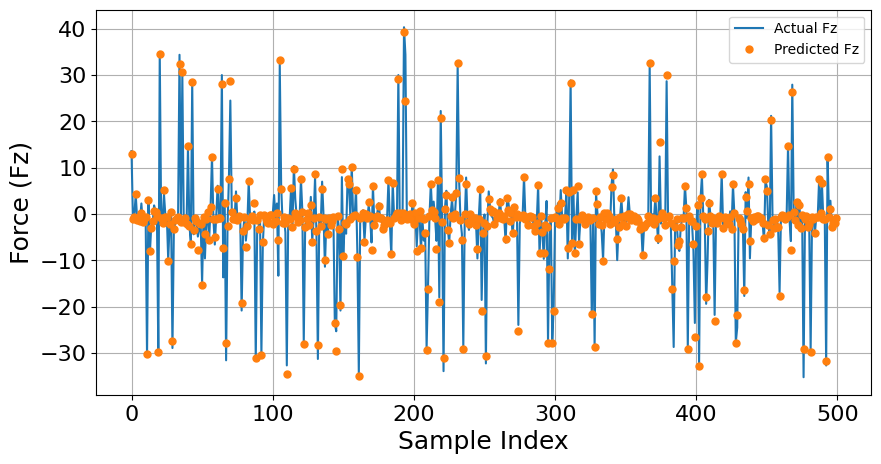

['scaler_y.pkl']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import random
import tensorflow as tf

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)  # Seed for NumPy
random.seed(seed_value)     # Seed for Python random
tf.random.set_seed(seed_value)  # Seed for TensorFlow

# 1. Load dataset
data = pd.read_excel('new.xlsx')  # Ganti dengan nama file Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X = data[['Magx', 'Magy', 'Magz']].values  # Mengambil kolom medan magnet
y = data[['Fx', 'Fy', 'Fz']].values  # Mengambil kolom gaya

# 2. Normalisasi data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# 3. Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_seq, y_seq = [], []

for i in range(len(X_scaled) - time_steps):
    X_seq.append(X_scaled[i:i + time_steps])  # Membentuk urutan data input dengan 10 timestep
    y_seq.append(y_scaled[i + time_steps])  # Target output setelah 10 timestep

X_seq = np.array(X_seq)
y_seq = np.array(y_seq)

# Periksa dimensi data setelah membentuk sequence
print("Shape X_seq:", X_seq.shape)  # (samples, timestep, features)
print("Shape y_seq:", y_seq.shape)  # (samples, output_dim)

# 4. Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=seed_value)

# 5. Model LSTM
model = Sequential()

# Layer pertama LSTM dengan Dropout
model.add(LSTM(160, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

# Layer kedua LSTM dengan Dropout
model.add(LSTM(160, return_sequences=False))
model.add(Dropout(0.2))

# Fully connected layer
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1], activation='linear'))

# 6. Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# 7. Callbacks (Early Stopping dan Reduce LR on Plateau)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)

# 8. Train model
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=500,
                    batch_size=64,
                    callbacks=[early_stopping, reduce_lr])

# 9. Plot hasil pelatihan (Training vs Validation Loss)
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
#plt.title('Loss History')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend()
plt.grid()
plt.xticks(fontsize=16)  # Atur ukuran font pada tick sumbu x
plt.yticks(fontsize=16)  # Atur ukuran font pada tick sumbu y
plt.savefig('Loss History.png')  # Simpan gambar Fx
plt.show()

# 10. Evaluasi (Mean Squared Error dan R² Score untuk setiap sumbu)

# Prediksi data validasi
y_pred = model.predict(X_val)

# Inverse transform prediksi dan nilai aktual agar kembali ke skala asli
y_val_original = scaler_y.inverse_transform(y_val)
y_pred_original = scaler_y.inverse_transform(y_pred)

# MSE dan R² Score untuk setiap sumbu (Fx, Fy, Fz)
mse_fx = mean_squared_error(y_val_original[:, 0], y_pred_original[:, 0])
mse_fy = mean_squared_error(y_val_original[:, 1], y_pred_original[:, 1])
mse_fz = mean_squared_error(y_val_original[:, 2], y_pred_original[:, 2])

r2_fx = r2_score(y_val_original[:, 0], y_pred_original[:, 0])
r2_fy = r2_score(y_val_original[:, 1], y_pred_original[:, 1])
r2_fz = r2_score(y_val_original[:, 2], y_pred_original[:, 2])

print(f'MSE Fx: {mse_fx}, R² Fx: {r2_fx}')
print(f'MSE Fy: {mse_fy}, R² Fy: {r2_fy}')
print(f'MSE Fz: {mse_fz}, R² Fz: {r2_fz}')

# 11. Plot perbandingan nilai aktual vs nilai prediksi untuk setiap sumbu
# Tentukan indeks untuk 250 data terakhir (misal, dari 2750 hingga 3000)

# Plot untuk Fx (250 data prediksi terakhir dengan urutan aslinya)
plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:500, 0], label='Actual Fx', linestyle='-')  # Garis solid untuk data aktual
plt.plot(y_pred_original[:500, 0], label='Predicted Fx', marker='.', linestyle='', markersize=10)  # Titik untuk prediksi
#plt.title('Fx: Actual vs Predicted (Last 250 Samples)', fontsize=14)  # Perbesar judul
plt.xlabel('Sample Index', fontsize=18)  # Perbesar label sumbu x
plt.ylabel('Force (Fx)', fontsize=18)  # Perbesar label sumbu y
plt.legend()
plt.grid()
plt.xticks(fontsize=16)  # Atur ukuran font pada tick sumbu x
plt.yticks(fontsize=16)  # Atur ukuran font pada tick sumbu y
plt.savefig('Fx_Comparison_Last_250.png')  # Simpan gambar Fx
plt.show()

# Plot untuk Fy (250 data prediksi terakhir dengan urutan aslinya)
plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:500, 1], label='Actual Fy', linestyle='-')  # Garis solid untuk data aktual
plt.plot(y_pred_original[:500, 1], label='Predicted Fy', marker='.', linestyle='', markersize=10)  # Titik untuk prediksi
#plt.title('Fy: Actual vs Predicted (Last 250 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=18)
plt.ylabel('Force (Fy)', fontsize=18)
plt.legend()
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Fy_Comparison_Last_250.png')  # Simpan gambar Fy
plt.show()

# Plot untuk Fz (250 data prediksi terakhir dengan urutan aslinya)
plt.figure(figsize=(10, 5))
plt.plot(y_val_original[:500, 2], label='Actual Fz', linestyle='-')  # Garis solid untuk data aktual
plt.plot(y_pred_original[:500, 2], label='Predicted Fz', marker='.', linestyle='', markersize=10)  # Titik untuk prediksi
#plt.title('Fz: Actual vs Predicted (Last 250 Samples)', fontsize=14)
plt.xlabel('Sample Index', fontsize=18)
plt.ylabel('Force (Fz)', fontsize=18)
plt.legend()
plt.grid()
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Fz_Comparison_Last_250.png')  # Simpan gambar Fz
plt.show()

# 13. Simpan model
model.save('LSTM_ModelFix.h5')
joblib.dump(scaler_X, 'scaler_X.pkl')  # Simpan scaler ke file
joblib.dump(scaler_y, 'scaler_y.pkl')


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MSE Fx: 0.2818653795999738, R² Fx: 0.9722097113832334
MSE Fy: 0.35672485619414307, R² Fy: 0.979506089683666
MSE Fz: 2.8085545410058823, R² Fz: 0.9712980439614555


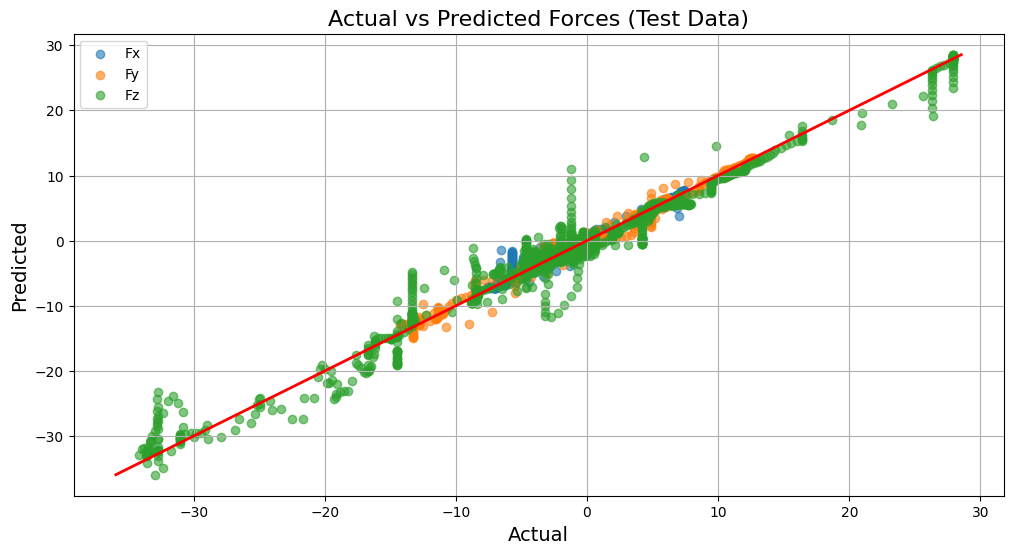

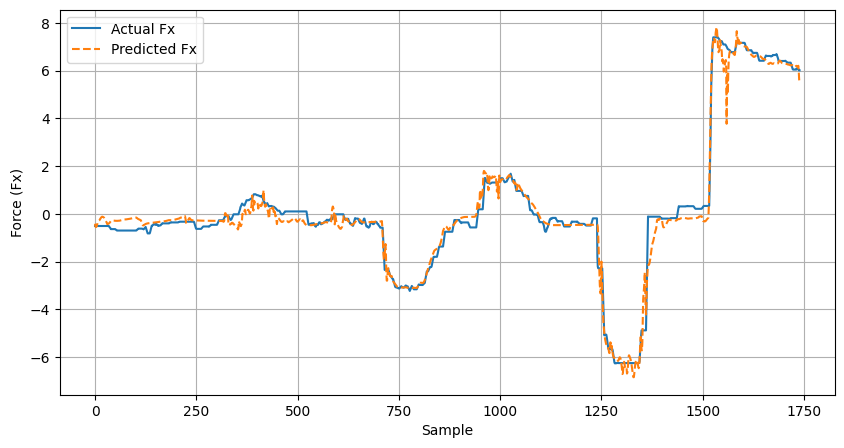

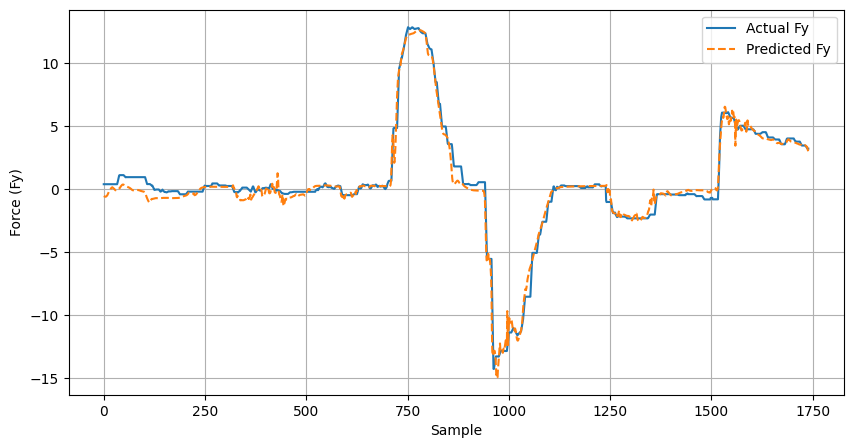

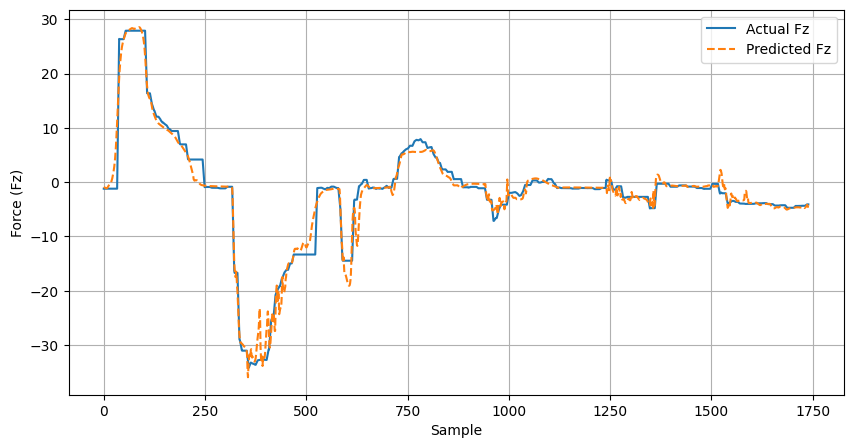

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
import joblib

# Set seed for reproducibility
seed_value = 42
np.random.seed(seed_value)

# 1. Load dataset untuk pengujian
test_data = pd.read_excel('dataUji.xlsx')  # Ganti dengan nama file dataset uji Anda

# Input (medan magnet) dan output (gaya pada tiga sumbu)
X_test = test_data[['Magx', 'Magy', 'Magz']].values
y_test = test_data[['Fx', 'Fy', 'Fz']].values

# 2. Load scaler dan normalisasi data uji
scaler_X = joblib.load('scaler_X.pkl')
scaler_y = joblib.load('scaler_y.pkl')

X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test)

# Membentuk data menjadi sequence dengan timestep = 10
time_steps = 10
X_test_seq, y_test_seq = [], []

for i in range(len(X_test_scaled) - time_steps):
    X_test_seq.append(X_test_scaled[i:i + time_steps])
    y_test_seq.append(y_test_scaled[i + time_steps])

X_test_seq = np.array(X_test_seq)
y_test_seq = np.array(y_test_seq)

# 3. Load model LSTM
model = load_model('LSTM_ModelFix.h5')

# 4. Prediksi data uji
y_pred_scaled = model.predict(X_test_seq)

# Inverse transform prediksi dan nilai aktual agar kembali ke skala asli
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_original = scaler_y.inverse_transform(y_test_seq)

# 5. Evaluasi kinerja model
mse_fx = mean_squared_error(y_test_original[:, 0], y_pred[:, 0])
mse_fy = mean_squared_error(y_test_original[:, 1], y_pred[:, 1])
mse_fz = mean_squared_error(y_test_original[:, 2], y_pred[:, 2])

r2_fx = r2_score(y_test_original[:, 0], y_pred[:, 0])
r2_fy = r2_score(y_test_original[:, 1], y_pred[:, 1])
r2_fz = r2_score(y_test_original[:, 2], y_pred[:, 2])

print(f'MSE Fx: {mse_fx}, R² Fx: {r2_fx}')
print(f'MSE Fy: {mse_fy}, R² Fy: {r2_fy}')
print(f'MSE Fz: {mse_fz}, R² Fz: {r2_fz}')

# 6. Visualisasi hasil prediksi vs aktual
plt.figure(figsize=(12, 6))
plt.scatter(y_test_original[:, 0], y_pred[:, 0], label='Fx', alpha=0.6)
plt.scatter(y_test_original[:, 1], y_pred[:, 1], label='Fy', alpha=0.6)
plt.scatter(y_test_original[:, 2], y_pred[:, 2], label='Fz', alpha=0.6)
plt.plot([min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())],
         [min(y_test_original.min(), y_pred.min()), max(y_test_original.max(), y_pred.max())],
         color='red', linewidth=2)
plt.title('Actual vs Predicted Forces (Test Data)', fontsize=16)
plt.xlabel('Actual', fontsize=14)
plt.ylabel('Predicted', fontsize=14)
plt.legend()
plt.grid()
plt.show()

# 7. Visualisasi hasil prediksi untuk setiap sumbu
plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 0], label='Actual Fx')
plt.plot(y_pred[250:2000, 0], label='Predicted Fx', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fx)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 1], label='Actual Fy')
plt.plot(y_pred[250:2000, 1], label='Predicted Fy', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fy)')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(y_test_original[250:2000, 2], label='Actual Fz')
plt.plot(y_pred[250:2000, 2], label='Predicted Fz', linestyle='--')
plt.xlabel('Sample')
plt.ylabel('Force (Fz)')
plt.legend()
plt.grid()
plt.show()
